In [32]:
from importlib import reload
import os
import data_processing as dp
import numpy as np
import pandas as pd
dp = reload(dp)

In [4]:
def dir_filter(directory):
    dir_name = directory.name
    name_index = dir_name.split("_")
    return name_index[0] == "explore"

root = os.getcwd()
output_path = os.path.join(root, "..", "output")
dirs = list(os.scandir(output_path))

# observables to investigate
obs_names = ["dual_graph_shell", "dual_tree_shell", "edge_degree", "edge_detour", "edge_freq", "edge_middle", "triangle_detour", "triangle_freq", "triangle_middle", "vertex_count", "vertex_degree", "vertex_tree_shell", "volume"]
#obs_names = ["dual_dist_prof", "edge_degree", "edge_detour", "edge_middle", "triangle_detour", "triangle_middle", "vertex_count", "vertex_degree", "volume"]

# build a container
all_data = np.empty((len(obs_names), 6), dtype=object)
for i in range(all_data.shape[0]):
    for j in range(all_data.shape[1]):
        all_data[i][j] = []

# gather the data
for directory in dirs:
    if dir_filter(directory):
        dirname = directory.name

        for i in range(len(obs_names)):
            obs_data = dp.DataSet.load(dirname, obs_names[i])
            obs_max = obs_data.transform(trans="max")
            obs_parity = obs_data.transform(trans="parity")
            all_data[i][0].append(obs_data.histogram())
            all_data[i][1].append(obs_max.histogram())
            all_data[i][2].append(obs_max.bootstrap("mean", 1000))
            all_data[i][3].append(obs_max.bootstrap("std", 1000))
            all_data[i][4].append(obs_parity.bootstrap("mean", 1000))
            all_data[i][5].append(obs_parity.bootstrap("std", 1000))
        print("And another one!")


And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another one!
And another on

In [21]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def kappa_curve(N, kappa_c, c, nu):
    return kappa_c + c * np.power(N, -nu)


   volume     kappa       value
0     200  0.527030   10.743528
1     400  0.053543   20.079156
2     800 -0.267624   35.512705
3    1600 -0.567346   65.702622
4    3200 -0.730209  121.832828
5    6400 -0.834625  211.693126
[-1.18281927 20.91547542  0.47219978]


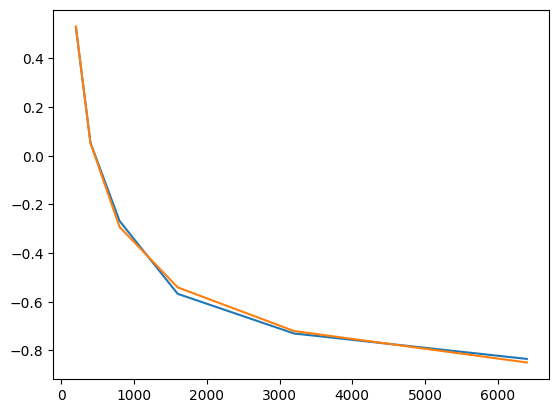

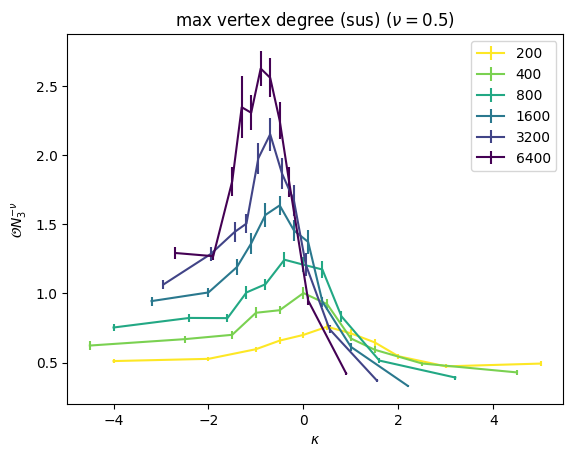

In [33]:

# find peaks
df = dp.process_volume_kappa(all_data[10][3])
dp.write_data_frame(df, "test")
df_peak = dp.get_peak_data(df)
print(df_peak)

# fit curve
popt, pcov = curve_fit(kappa_curve, df_peak["volume"], df_peak["kappa"], bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
print(popt)
plt.plot(df_peak["volume"], df_peak["kappa"])
plt.plot(df_peak["volume"], kappa_curve(df_peak["volume"], *popt))
plt.show()

dp.volume_kappa_plot(df, 0.5, title="max vertex degree (sus)")

   volume     kappa       value
0    1600 -1.418707   50.194383
1    3200 -1.100536   79.938005
2    6400 -1.253758  142.817667
[-1.25766874  0.93182151  4.42997936]


/home/tom/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


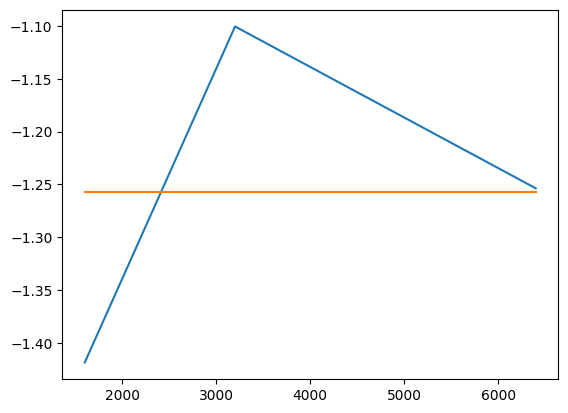

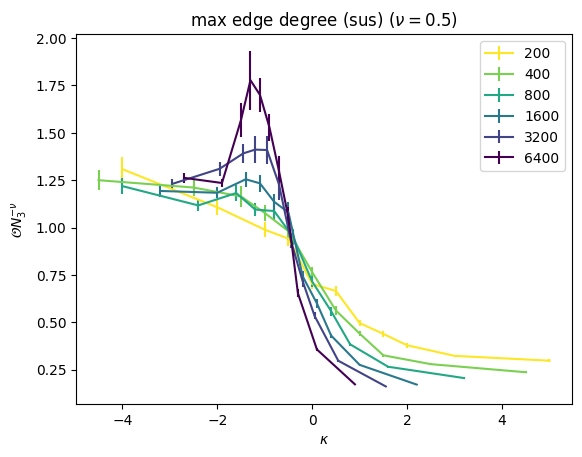

In [34]:
# find peaks
df = dp.process_volume_kappa(all_data[2][3])
dp.write_data_frame(df, "test")
df_peak = dp.get_peak_data(df)
print(df_peak)

# fit curve
popt, pcov = curve_fit(kappa_curve, df_peak["volume"], df_peak["kappa"], bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
print(popt)
plt.plot(df_peak["volume"], df_peak["kappa"])
plt.plot(df_peak["volume"], kappa_curve(df_peak["volume"], *popt))
plt.show()

dp.volume_kappa_plot(df, 0.5, title="max edge degree (sus)")

In [1]:
dp.volume_kappa_plot(all_data[6][2], 0.5, title="Max vertex degree (mean)")
dp.volume_kappa_plot(all_data[6][3], 0.5, title="Max vertex degree (std)")
dp.volume_kappa_plot(all_data[1][2], 0.5, title="Max edge degree (mean)")
dp.volume_kappa_plot(all_data[1][3], 0.5, title="Max edge degree (std)")


NameError: name 'dp' is not defined

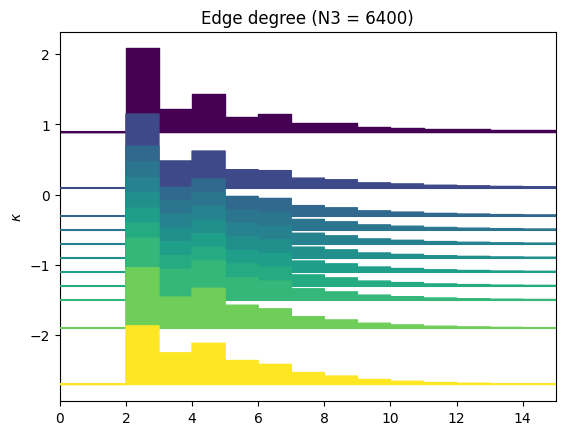

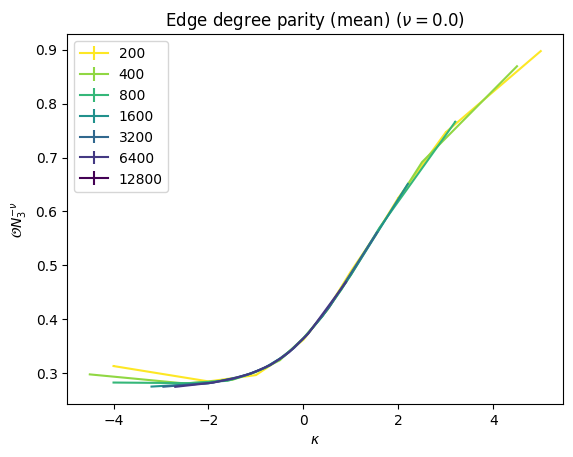

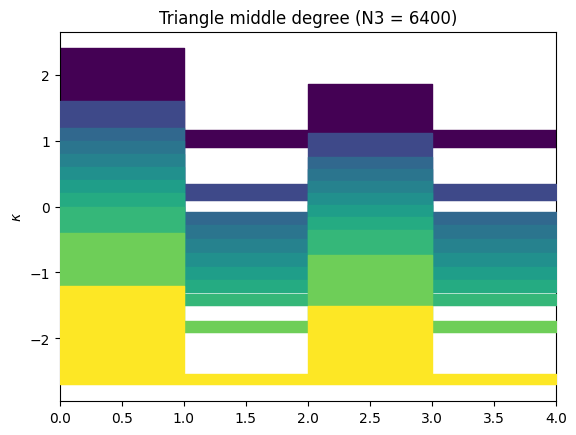

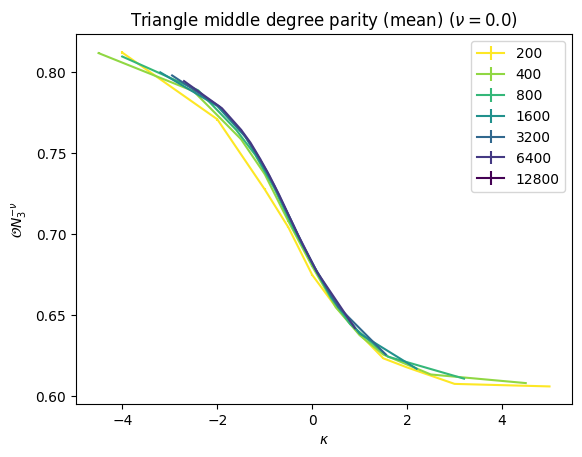

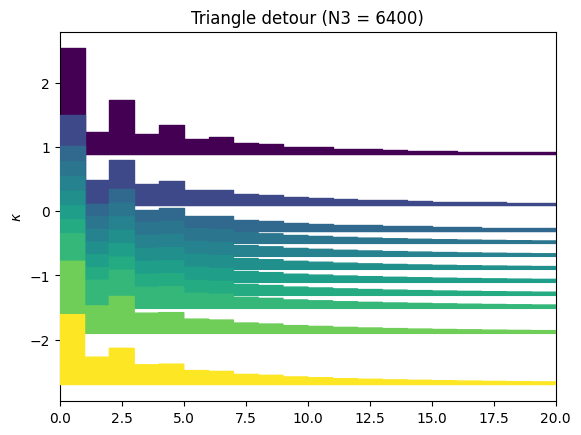

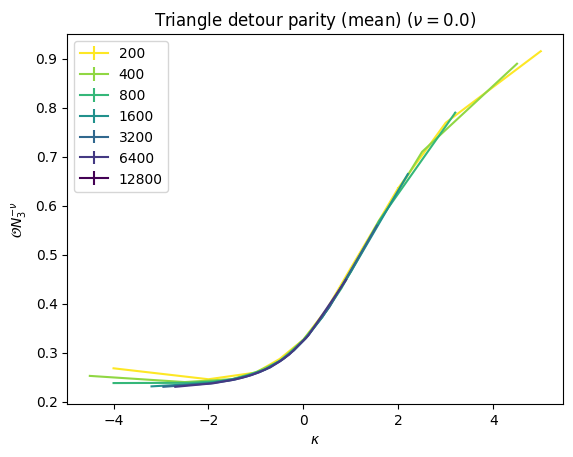

In [5]:

dp.hist_plot(all_data[1][0], 6400, 15, 3, title="Edge degree")
dp.volume_kappa_plot(all_data[1][4], 0.0, title="Edge degree parity (mean)")
dp.hist_plot(all_data[5][0], 6400, 4, 3, title="Triangle middle degree")
dp.volume_kappa_plot(all_data[5][4], 0.0, title="Triangle middle degree parity (mean)")
dp.hist_plot(all_data[4][0], 6400, 20, 5, title="Triangle detour")
dp.volume_kappa_plot(all_data[4][4], 0.0, title="Triangle detour parity (mean)")


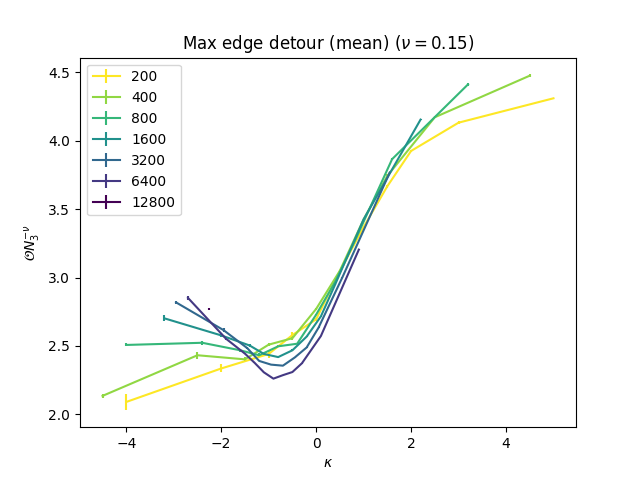

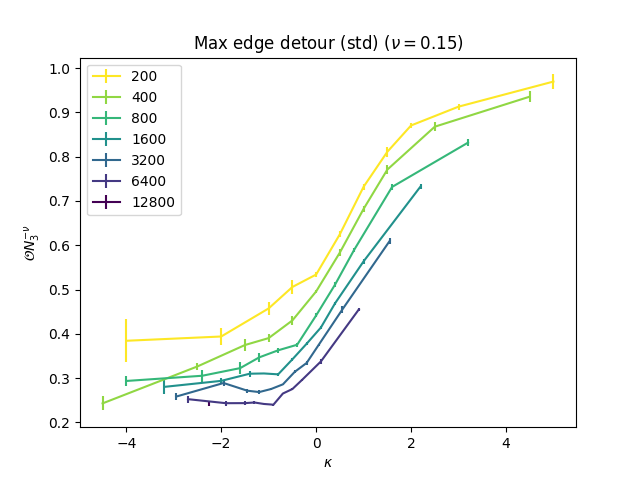

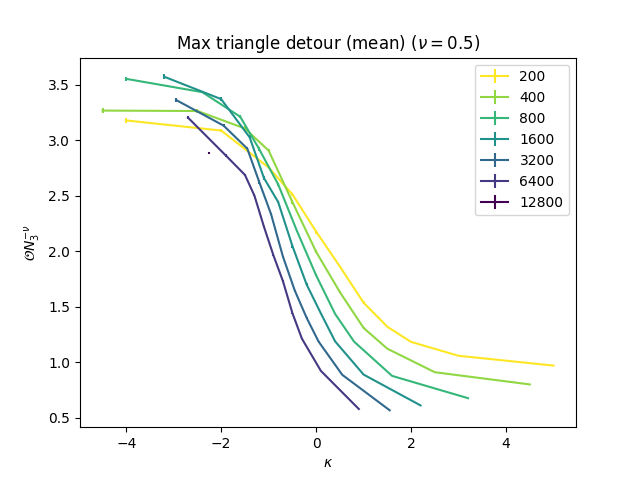

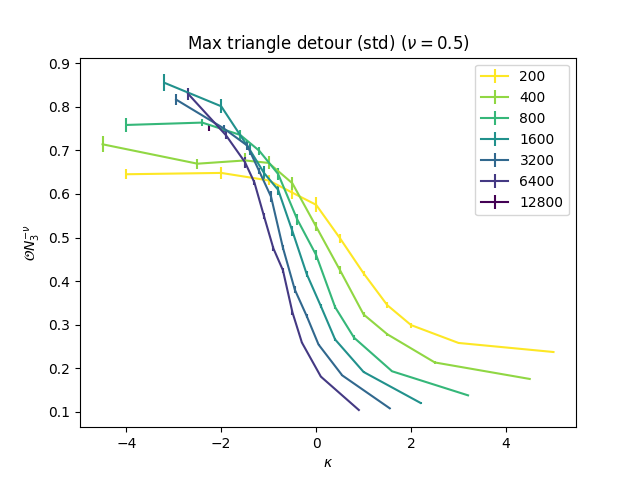

In [13]:

dp.volume_kappa_plot(all_data[2][2], 0.15, title="Max edge detour (mean)")
dp.volume_kappa_plot(all_data[2][3], 0.15, title="Max edge detour (std)")
dp.volume_kappa_plot(all_data[4][2], 0.5, title="Max triangle detour (mean)")
dp.volume_kappa_plot(all_data[4][3], 0.5, title="Max triangle detour (std)")

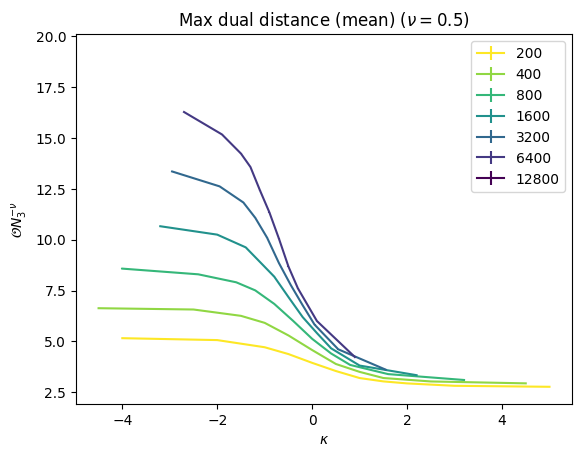

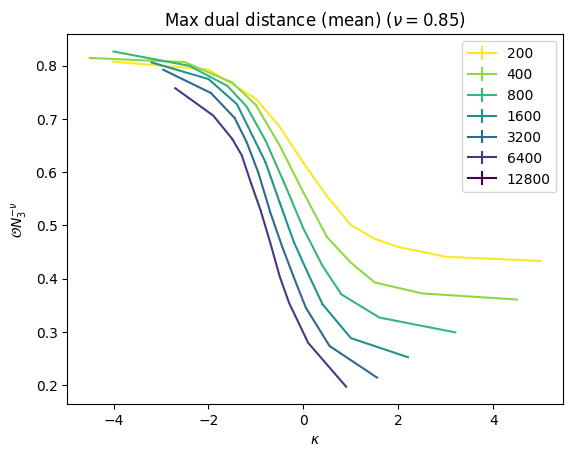

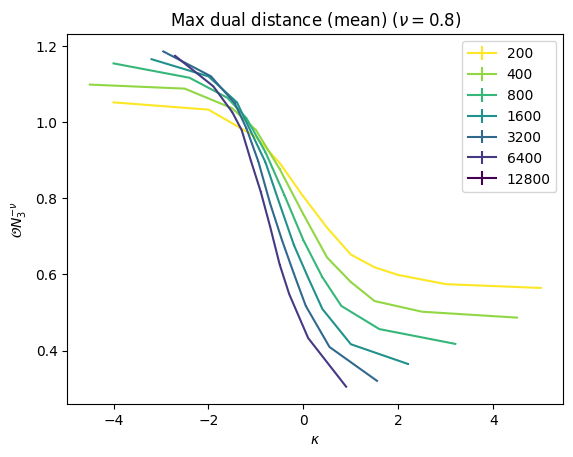

In [7]:
dp.volume_kappa_plot(all_data[0][2], 0.5, title="Max dual distance (mean)")
dp.volume_kappa_plot(all_data[0][2], 0.85, title="Max dual distance (mean)")
dp.volume_kappa_plot(all_data[0][2], 0.8, title="Max dual distance (mean)")


In [ ]:
%matplotlib widget
for i in range(len(obs_names)):
    #dp.hist_plot(all_data[i][0], 6400, xmax_list[i], 50)
    #dp.hist_plot(all_data[i][1], 6400, xmax_list[i], 50)
    df_max_mean = dp.process_volume_kappa(all_data[i][2])
    df_max_sus = dp.process_volume_kappa(all_data[i][3])
    df_par_mean = dp.process_volume_kappa(all_data[i][4])
    df_par_sus = dp.process_volume_kappa(all_data[i][5])
    dp.write_data_frame(df_max_mean, f"{obs_names[i]}_max")
    dp.write_data_frame(df_max_sus, f"{obs_names[i]}_max_sus")
    dp.write_data_frame(df_par_mean, f"{obs_names[i]}_par")
    dp.write_data_frame(df_par_sus, f"{obs_names[i]}_par_sus")
    dp.volume_kappa_plot(df_max_mean, 0.5, title=f"max {obs_names[i]}")
    dp.volume_kappa_plot(df_max_sus, 0.5, title=f"max {obs_names[i]} - susceptibility")
    dp.volume_kappa_plot(df_par_mean, 0.5, title=f"par {obs_names[i]}")
    dp.volume_kappa_plot(df_par_sus, 0.5, title=f"par {obs_names[i]} - susceptibility")